In [2]:
import os
import requests
import zipfile
import pathlib
from pathlib import Path

import random 
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, Dict, List

import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [4]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
# device = torch.device('mps')

## Globally set devices
One of my favourite new features in PyTorch 2.x is being able to set the default device type via:

1. Context manager
2. Globally

Previously, you could only set the default device type via:

1. `tensor.to(device)`

Let's see these two new device settings in action.

In [5]:
# Set the device with context manager (requires PyTorch 2.x+)
with torch.device(device):
    # All tensors created in this block will be on device
    layer = torch.nn.Linear(20, 30)
    print(f"Layer weights are on device: {layer.weight.device}")
    print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cpu
Layer creating data on device: cpu


In [10]:
# Set the device globally
# All tensors created from now on in this file will be on the global device by default
torch.set_default_device(device)

# All tensors created from now on in this file will be on the global device by default
layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cpu
Layer creating data on device: cpu


In [7]:
os.cpu_count()

10

## 1. Get data
Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [1]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else: 
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suhsi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  # Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


In [2]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
     

In [3]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


## 2. Becoming one with the data (data preparation and data exploration)

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg')]
Random Image: data/pizza_steak_sushi/train/pizza/765799.jpg
Image class pizza
Random image path: data/pizza_steak_sushi/train/pizza/765799.jpg
Image class: pizza
Image height: 512
Image width: 511


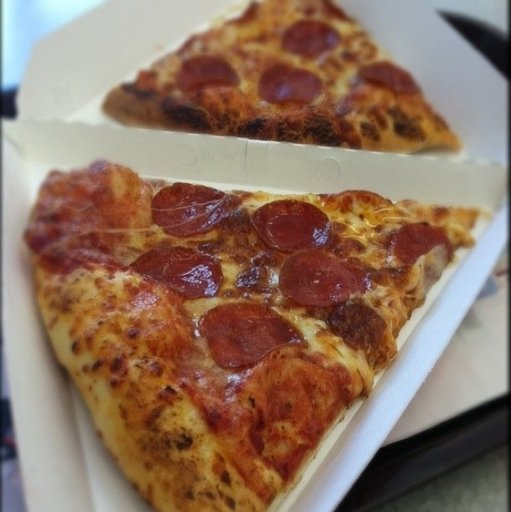

In [11]:
import random 
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))


print(image_path_list[0:10])

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

print("Random Image:", random_image_path)

# 3. Get image class from path name (the image class is the name 
# of the directory where the image is stored)
image_class = random_image_path.parent.stem
print("Image class", image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata 
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


(512, 511, 3)
[[[103 133 131]
  [135 165 163]
  [168 200 199]
  ...
  [ 83  92  91]
  [ 54  63  62]
  [ 39  45  43]]

 [[103 133 131]
  [135 165 163]
  [168 200 199]
  ...
  [ 83  92  91]
  [ 54  63  62]
  [ 39  45  43]]

 [[103 133 131]
  [135 165 163]
  [168 200 199]
  ...
  [ 83  92  91]
  [ 55  64  63]
  [ 39  45  43]]

 ...

 [[ 56  64  83]
  [ 71  79  98]
  [ 89  97 120]
  ...
  [ 66  67  62]
  [ 47  48  43]
  [ 36  37  32]]

 [[ 57  65  84]
  [ 72  80  99]
  [ 90  98 121]
  ...
  [ 67  68  63]
  [ 47  48  43]
  [ 37  38  33]]

 [[ 58  66  85]
  [ 73  81 100]
  [ 91  99 122]
  ...
  [ 68  69  64]
  [ 48  49  44]
  [ 37  38  33]]]


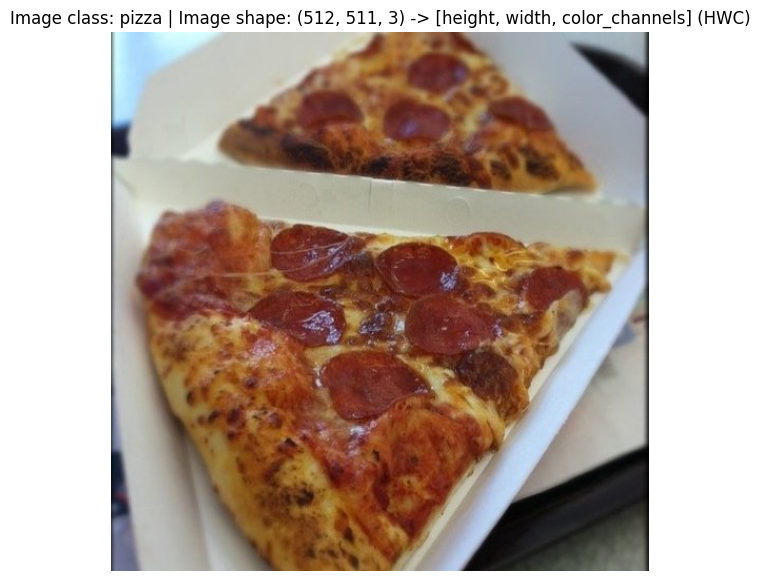

In [16]:
## Visualizing image with matplotlib



import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)


print(img_as_array.shape)
print(img_as_array)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);


## 3. Transforming data

Before we can use our image data with PyTorch:

1. Turn your target data into `tensors` (in our case, numerical representation of our images).

2. Turn it into a `torch.utils.data.Dataset` and  subsequently a `torch.utils.data.DataLoader`, we'll call these Dataset and DataLoader

In [18]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



# Write a transform for image (this is how we want to transform one single image)

data_transform = transforms.Compose([
  # Resize our images to 64x64
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on the horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor() # Convert a PIL Image (H, W, C) or ndarray to tensor (C, H, W) and scale the values accordingly.
])

In [20]:
transformed_image = data_transform(img)

transformed_image.shape

torch.Size([3, 64, 64])

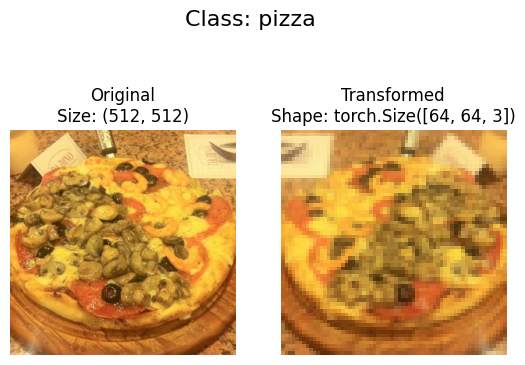

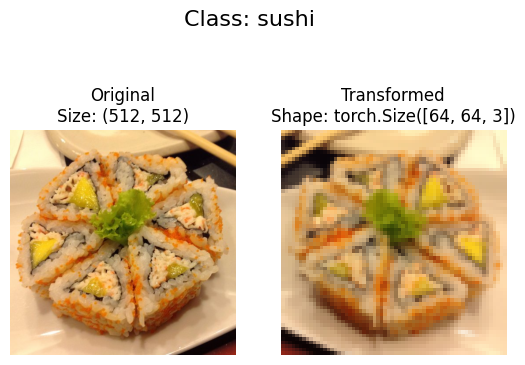

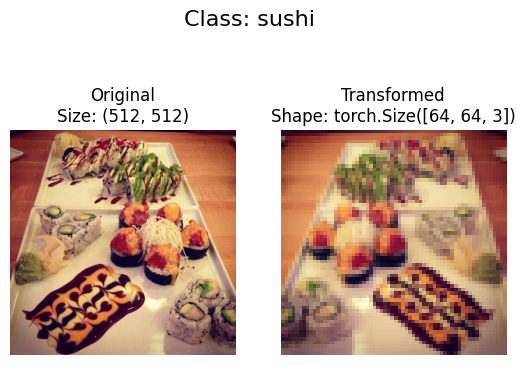

In [21]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms 
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
    
  # Seelct 3 random images to plot 
  random_image_paths = random.sample(image_paths, k=n)
    
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
    
      # Plot original image on axis 0 (row 1, col 1)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Plot transformed image on axis 1 (row 1, col 2)
      # Transform and plot target image
      # Matplotlib expects images to be in the format (H, W, C)
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
    
    
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)


## 4. Loading data into the pytorch dataset 

### Option 1: Loading image data using ImageFolder

In [22]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [41]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  # Applies transfrom to every single image.
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target 

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [42]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [25]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [26]:

# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [31]:
 train_data.targets[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [32]:
train_data.samples[0:10]

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/12301.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1285298.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/138855.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1412034.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1524655.jpg', 0)]

In [38]:

# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Label datatype: {type(label)}")
print(f"Image label: {label}")
print(f"Image tensor:\n {img}")

Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Label datatype: <class 'int'>
Image label: 0
Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.094

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

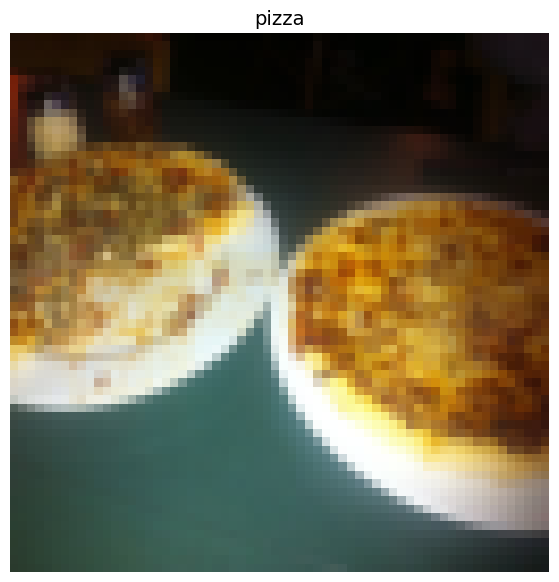

In [39]:
# Rearrange the order dimensions for the matplotlib
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

 #### Turn loaded images `(dataset)` into `DataLoader's`

In [45]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=32 # number of images in each batch
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1, # how many cpu cores to load the data.
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x3048b3310>,
 <torch.utils.data.dataloader.DataLoader at 0x30541b410>)

In [46]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [47]:
# Get the first batch out of 8 batches
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


### Option 2: Loading Image Data with a Custom Dataset Class that can be then used with DataLoader class

In [57]:
target_directory = train_dir

print("Target Directory:", target_directory)

# Get the class names from the target directory

for entry in list(os.scandir(target_directory)):
    print(entry)
    print(entry.name)

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])

print("Found classnames", class_names_found)

Target Directory: data/pizza_steak_sushi/train
<DirEntry 'steak'>
steak
<DirEntry 'sushi'>
sushi
<DirEntry 'pizza'>
pizza
Found classnames ['pizza', 'steak', 'sushi']


In [ ]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom()

In [59]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [60]:

find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [63]:
print(target_directory)
list(Path(target_directory).glob("*/*.jpg"))

data/pizza_steak_sushi/train


[PosixPath('data/pizza_steak_sushi/train/steak/239025.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1598345.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3074367.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2979061.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/914570.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/167069.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/231296.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2324994.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2603058.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1961025.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1615395.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2606444.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/355715.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2163079.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1736968.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2878151.jpg'),
 PosixPath('d

In [78]:
first_img = list(Path(target_directory).glob("*/*.jpg"))[0]

print(first_img)
print(first_img.parent)
print(first_img.parent.name)

data/pizza_steak_sushi/train/steak/239025.jpg
data/pizza_steak_sushi/train/steak
steak


In [79]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self, 
               root: str, # target directory
               transform=None):
        
    # 3. Create class attributes
    
    # Get all of the image paths in the root folder
    self.paths = list(pathlib.Path(root).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(root)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)
  
  # Required method
  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [70]:
train_data # (created with built in datasets.ImageFolder)

train_data[0] # tuple of (img_tensor, label)


# this is what we want __getitem__ to replicate
# When we index train_data, __getitem__ should return
# a tuple of corresponding image and label
img, label = train_data[0] 

print(img.shape, label)

# this is what we want __getitem__ to replicate

torch.Size([3, 64, 64]) 0


In [80]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
                                      transforms.Resize(size=(64, 64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor() 
])

test_transforms = transforms.Compose([
                                      transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()
])

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [83]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(root=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(root=test_dir,
                                     transform=test_transforms)

In [84]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x30495bb90>,
 <__main__.ImageFolderCustom at 0x3054bac50>)

In [86]:
len(train_data), len(test_data_custom)

(225, 75)

In [87]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [88]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [89]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


In [90]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  # targ_sample is the radom index of the sample from the dataset
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title) 

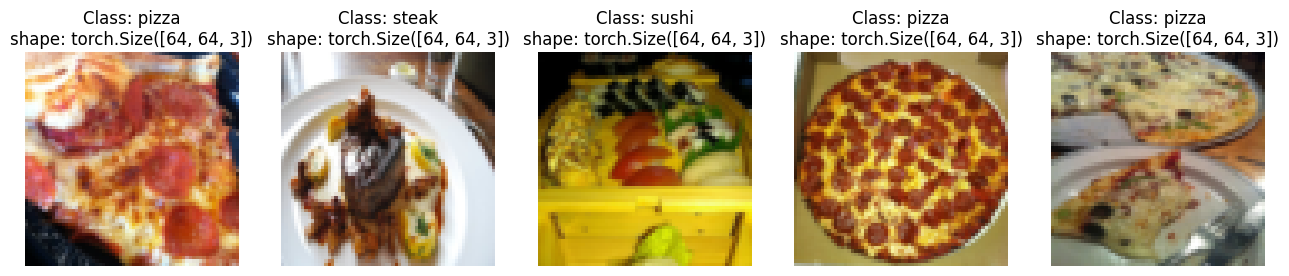

In [91]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5, 
                      classes=class_names,
                      seed=None)

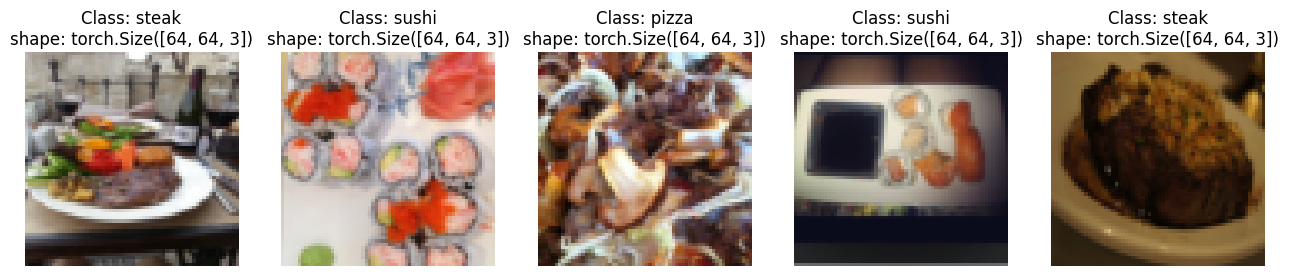

In [92]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)
     

### Turn custom loaded images (Custom Dataset Class) into DataLoader's

In [95]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
# NUM_WORKERS = os.cpu_count()
NUM_WORKERS = 0
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x177935a10>,
 <torch.utils.data.dataloader.DataLoader at 0x3057e5fd0>)

In [98]:
len(train_dataloader_custom), len( test_dataloader_custom)

(225, 75)

In [96]:
# Get the first batch out of 225 batches
# Get image and label from custom datloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 5. Other forms of transforms (data augmentation)

In [100]:
# Let's look at trivialaugment - https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide
# Trivial Augment randomly applies different kinds of transformations (like rotate, crop, zoop etch) randomly
# to our images.
from torchvision import transforms

train_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.ToTensor()
])

In [101]:
image_path

PosixPath('data/pizza_steak_sushi')

In [102]:

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg')]

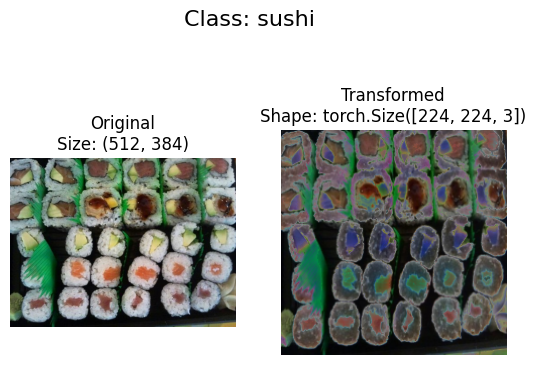

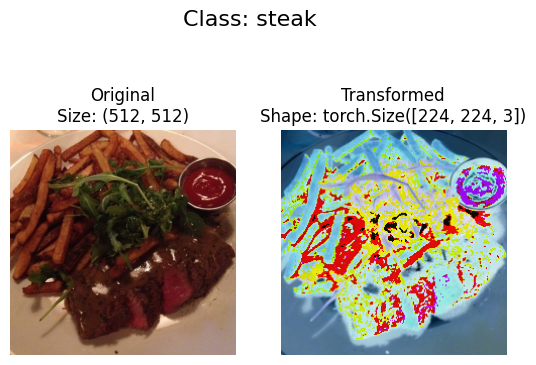

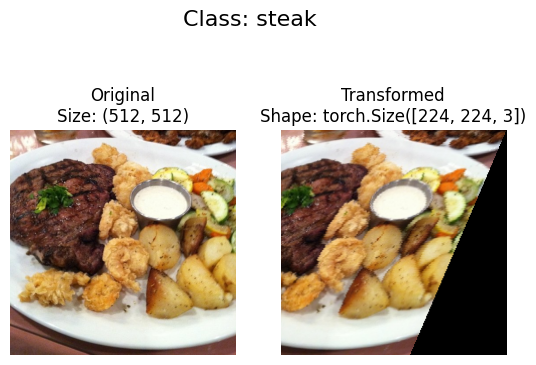

In [105]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 6. Model Training

In [107]:
# Create simple transform
simple_transform = transforms.Compose([
                                       transforms.Resize(size=(64, 64)),
                                       transforms.ToTensor()
])

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [110]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
# NUM_WORKERS = os.cpu_count()
NUM_WORKERS = 0

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)


print(len(train_dataloader_simple)) # 8 batches of 32 images each
print(len(test_dataloader_simple))  # 3 batches of 32 images each

8
3


In [150]:
class TinyVGG(nn.Module):
    """
     Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
    """
    
    def __init__(self, input_channels, num_kernels, output_shape):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
           nn.Conv2d(
               in_channels=input_channels, 
               out_channels=num_kernels,
               kernel_size = (3, 3),
               stride = 1,
               padding = 0),
            nn.ReLU(),
            nn.Conv2d(
               in_channels=num_kernels, 
               out_channels=num_kernels,
               kernel_size = (3, 3),
               stride = 1,
               padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(
               kernel_size = 2,
               stride =2 
            ) # default stride value is same as kernel_size for MaxPool2d
        )
        
        self.conv_block_2 = nn.Sequential(
           nn.Conv2d(
               in_channels=num_kernels, 
               out_channels=num_kernels,
               kernel_size = (3, 3),
               stride = 1,
               padding = 0),
            nn.ReLU(),
            nn.Conv2d(
               in_channels=num_kernels, 
               out_channels=num_kernels,
               kernel_size = (3, 3),
               stride = 1,
               padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(
               kernel_size = 2,
               stride =2 
            ) # default stride value is same as kernel_size for MaxPool2d
        )
        
        self.linear_block = nn.Sequential(
             nn.Flatten(),
             nn.Linear(
                in_features = num_kernels * 13 * 13,
                out_features = output_shape
             )
        )
        
    def forward(self, x):
        z = self.conv_block_1(x)
        z = self.conv_block_2(z)
        # print(z.shape)
        # return nn.Flatten()(z)
        z = self.linear_block(z)
        return z
        
        # return self.linear_block(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion: https://horace.io/brrr_intro.html
     
        
        

In [151]:
torch.manual_seed(42)
model_0 = TinyVGG(input_channels=3, # number of color channels in our image data
                  num_kernels=10, 
                  output_shape=len(class_names))

In [153]:
# Try a forward pass on a single image (to test the model)

# Get a single image batch of 32 images
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [154]:
model_0(image_batch).shape

torch.Size([32, 3])

### Use torchinfo to get an idea of the shapes going through our model

In [155]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])  # input size is an example of size of the data that's going to flow through our model

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### Create train and test loops functions
`train_step()` - takes in a model and dataloader and trains the model on the dataloader.

`test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [164]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
    
    # Put the model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through the dataloader batches (each batch containing 32 images)
    for barch, (X, y) in enumerate(dataloader):
        # X is the batch of 32 images and y contains corresponding 32 label values
        # Send data to the target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_logits = model(X)
        
        # Calculate the loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        
        # Reset the gradients to prevent the gradients from accumulating
        optimizer.zero_grad()
        
        # Backpropagation
        loss.backward()
        
        # Gradient Descent
        optimizer.step()
        
        # Calculate the accuracy values
        y_pred_probs = torch.softmax(y_logits, dim=1)
        y_pred_class = torch.argmax(y_pred_probs, dim=1)
        correct_preds = (y_pred_class == y).sum().item()
        acc = correct_preds / len(y)
        
        train_acc += acc
        
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader) 
    return train_loss, train_acc

In [161]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader): 
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_probs = torch.softmax(test_pred_logits, dim=1)
      test_pred_class = torch.argmax(test_pred_probs, dim=1)
      test_correct_preds = (test_pred_class == y).sum().item()
      acc = test_correct_preds / len(y)
        
      test_acc += acc

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### Creating a train() function to combine train_step() and test_step()

In [162]:
# from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5, 
          device=device):
  
  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  
  # 3. Loop through training and testing steps for a number of epochs
  for epoch in range(epochs): # tqdm(range(epochs))
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    
    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  
  # 6. Return the filled results at the end of the epochs
  return results

### Train and evaluate model

In [166]:
train_data ## This is a dataset created with datasets.ImageFolder

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [196]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_channels=3, # number of color channels of our target images
                  num_kernels=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer() 

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0808 | Test acc: 0.4924
Epoch: 3 | Train loss: 1.0844 | Train acc: 0.3984 | Test loss: 1.0608 | Test acc: 0.5833
Epoch: 4 | Train loss: 1.0663 | Train acc: 0.4141 | Test loss: 1.0654 | Test acc: 0.5644
Epoch: 5 | Train loss: 1.0299 | Train acc: 0.4375 | Test loss: 1.0133 | Test acc: 0.5426
Epoch: 6 | Train loss: 0.9808 | Train acc: 0.4180 | Test loss: 0.9311 | Test acc: 0.6146
Epoch: 7 | Train loss: 0.9532 | Train acc: 0.5859 | Test loss: 1.0164 | Test acc: 0.4848
Epoch: 8 | Train loss: 0.9276 | Train acc: 0.5938 | Test loss: 1.0689 | Test acc: 0.3428
Epoch: 9 | Train loss: 1.0045 | Train acc: 0.4570 | Test loss: 1.0566 | Test acc: 0.4044
Total training time: 14.169 seconds


In [197]:
model_0_results

{'train_loss': [1.1063195765018463,
  1.0998011529445648,
  1.0868771374225616,
  1.0843935459852219,
  1.0662527233362198,
  1.0299162492156029,
  0.9808374643325806,
  0.9531716853380203,
  0.9275779128074646,
  1.0045409873127937],
 'train_acc': [0.3046875,
  0.328125,
  0.48828125,
  0.3984375,
  0.4140625,
  0.4375,
  0.41796875,
  0.5859375,
  0.59375,
  0.45703125],
 'test_loss': [1.0983215967814128,
  1.0696951548258464,
  1.080804745356242,
  1.0607737302780151,
  1.0654406150182087,
  1.0133355657259624,
  0.9310673475265503,
  1.0164362986882527,
  1.0689395268758137,
  1.056585689385732],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394,
  0.5426136363636364,
  0.6145833333333334,
  0.48484848484848486,
  0.3428030303030303,
  0.4043560606060606]}

### Plot the loss curves of Model 0
A loss curve is a way of tracking your model's progress over time.

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [198]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [199]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1) # nrows, ncols, index
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend() 

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

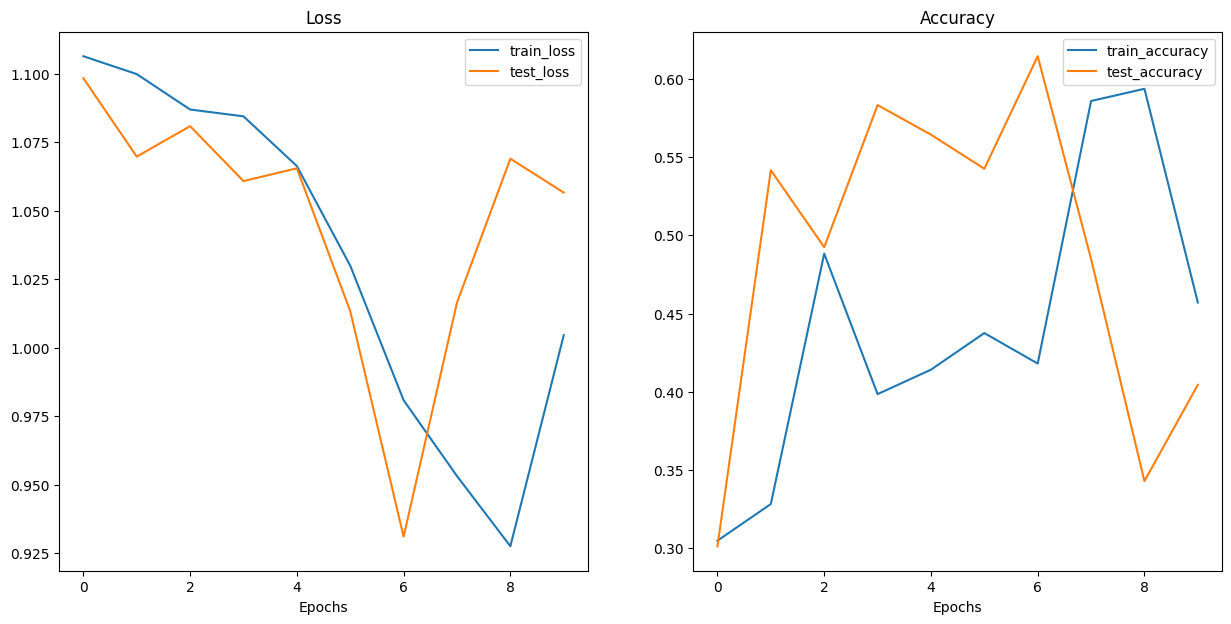

In [200]:

plot_loss_curves(model_0_results) 

### What should an ideal loss curve look like?
https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to troubleshoot a model.

In [203]:
model_0_results

{'train_loss': [1.1063195765018463,
  1.0998011529445648,
  1.0868771374225616,
  1.0843935459852219,
  1.0662527233362198,
  1.0299162492156029,
  0.9808374643325806,
  0.9531716853380203,
  0.9275779128074646,
  1.0045409873127937],
 'train_acc': [0.3046875,
  0.328125,
  0.48828125,
  0.3984375,
  0.4140625,
  0.4375,
  0.41796875,
  0.5859375,
  0.59375,
  0.45703125],
 'test_loss': [1.0983215967814128,
  1.0696951548258464,
  1.080804745356242,
  1.0607737302780151,
  1.0654406150182087,
  1.0133355657259624,
  0.9310673475265503,
  1.0164362986882527,
  1.0689395268758137,
  1.056585689385732],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394,
  0.5426136363636364,
  0.6145833333333334,
  0.48484848484848486,
  0.3428030303030303,
  0.4043560606060606]}

In [202]:
model_0_df = pd.DataFrame(model_0_results)

model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106320,0.304688,1.098322,0.301136
1,1.099801,0.328125,1.069695,0.541667
2,1.086877,0.488281,1.080805,0.492424
3,1.084394,0.398438,1.060774,0.583333
4,1.066253,0.414062,1.065441,0.564394
5,1.029916,0.437500,1.013336,0.542614
6,0.980837,0.417969,0.931067,0.614583
7,0.953172,0.585938,1.016436,0.484848
8,0.927578,0.593750,1.068940,0.342803
9,1.004541,0.457031,1.056586,0.404356


### Compare model results
After evaluating our modelling experiments on their own, it's important to compare them to each other (comparing results of different models and model architectures to each other)

There's a few different ways to do this:

1. Hard coding (what we're doing)
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases - https://wandb.ai/site/experiment-tracking
4. MLFlow - https://mlflow.org/

## 7. Making a prediction on a custom image

In [204]:
data_path # data_path = Path("data/")

PosixPath('data')

In [231]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

data/04-pizza-dad.jpeg already exists, skipping download...


We have to make sure our custom image is in the same format as the data our model was trained on.

1. In tensor form with datatype (torch.float32)
2. Of shape 64x64x3
3. On the right device

In [213]:
custom_image_path

PosixPath('data/04-pizza-dad.jpeg')

In [219]:
str(custom_image_path)

'data/04-pizza-dad.jpeg'

In [237]:
# Read in custom image

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")
print(f"Custom image tensor:\n {custom_image_uint8}")

     

Custom image shape: torch.Size([3, 4032, 3024])
Custom image datatype: torch.uint8
Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], d

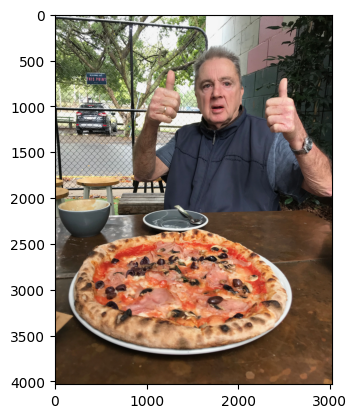

In [238]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));

In [239]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [240]:
custom_image_transform = transforms.Compose([
        transforms.Resize(size=(64, 64)) # transform to size 64 x 64 because our model was trained on the image size 64 x 64
])

# Transfrom target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


/Users/saalikmubeen/Dev/Machine Learning/personal-learning/venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


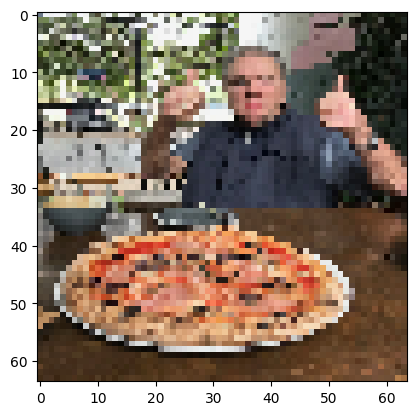

In [241]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))


In [246]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [247]:

# Make prediction
model_0.eval()
with torch.inference_mode():
    # need to add the batch dimension before passing to the model. Because that is what model expects
    # and was trained on
  custom_image_pred = model_0(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.1360, -0.2216, -0.4626]])

In [248]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.4447, 0.3110, 0.2444]])

In [249]:

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [250]:
class_names[custom_image_pred_label]

'pizza'

In [224]:
# Putting custom image prediction together: building a function

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x image)
    # [1, 3, 64, 64] | [batch, C, H, W]
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) # make sure the target image is on the right device

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert predction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape to be HWC
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

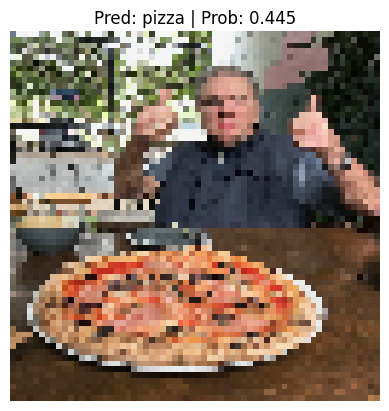

In [251]:
# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

# Using `%%writefile` magic command to turn code cells into python scripts

[https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile)


[Google's Style Guide for Python.](https://google.github.io/styleguide/pyguide.html#384-classes)

In [5]:
# %%writefile cell magic command writes the content of the cell in which 
# it's run to a file. This is useful to save the contents of the most useful
# code cells to reusable python scripts

# We can save a code cell's contents to a file using the Jupyter magic %%writefile filename -

# For example:
%%writefile going_modular/data_setup.py

In [7]:
%%writefile going_modular/data_setup.py
"""
Contains functionality for creating PyTorch DataLoader's for
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
  train_dir: str,
  test_dir: str,
  transform: transforms.Compose,
  batch_size: int,
  num_workers: int=NUM_WORKERS  
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directroy path and turns them into 
  PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=path/to/train_dir,
        test_dir=path/to/test_dir,
        transform=some_transform,
        batch_size=32,
        num_workers=4)
  """
  # Use ImageFolder to create datasets(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into DataLoaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True # for more on pin memory, see the PyTorch docs: https://pytorch.org/docs/stable/data.html 
  )

  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True
  )

  return train_dataloader, test_dataloader, class_names

Writing going_modular/data_setup.py
